clean and filter dataset by Status

In [1]:
import re
import pandas as pd

# --- 1) Load file ---
file_path = r"C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol.xlsx"
df = pd.read_excel(file_path)

# --- 2) Clean messy column names (remove _x000D_, newlines, extra spaces) ---
def clean_name(col: str) -> str:
    s = str(col)
    s = re.sub(r'_x000D_', ' ', s, flags=re.IGNORECASE)  # remove Excel's CR tokens
    s = s.replace('\r', ' ').replace('\n', ' ')          # remove line breaks
    s = re.sub(r'\s+', ' ', s).strip()                   # collapse spaces
    return s

df.columns = [clean_name(c) for c in df.columns]

print("Cleaned columns:\n", df.columns.tolist())

# --- 3) Find the methanol molar fraction column robustly ---
cands = []
for c in df.columns:
    lc = c.lower()
    if "methanol" in lc and ("molar" in lc or "mole" in lc) and "fraction" in lc:
        cands.append(c)
# common alternates (uncomment/add more if needed)
if not cands:
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in ["xmeoh", "meoh x", "meoh_x", "molefrac_meoh"]):
            cands.append(c)

assert cands, "Couldn't find a 'methanol molar fraction' column. Print df.columns and set it manually."
methanol_col = cands[0]
print("Detected methanol fraction column:", methanol_col)

# --- 4) Find Status column (case-insensitive) ---
status_col = None
for c in df.columns:
    if c.lower() == "status":
        status_col = c
        break
if status_col is None:
    for c in df.columns:
        if "status" in c.lower():
            status_col = c
            break
assert status_col is not None, "Couldn't find a 'Status' column."

# --- 5) Coerce methanol fraction to numeric (drop non-numeric) ---
df[methanol_col] = pd.to_numeric(df[methanol_col], errors="coerce")

# --- 6) Filter: methanol fraction present AND Status == OK ---
mask_ok = df[status_col].astype(str).str.strip().str.upper().eq("OK")
mask_has_meoh = df[methanol_col].notna()
df_clean = df[mask_ok & mask_has_meoh].copy().reset_index(drop=True)

print("✅ Cleaned shape:", df_clean.shape)
df_clean.head()


Cleaned columns:
 ['Row/Case', 'Status', 'VARY 1 HHX3 PARAM TEMP C', 'VARY 2 HHX3 PARAM PRES BAR', 'VARY 3 RECYCLE RECYCLED FRAC FRAC', 'VARY 4 SYNGAS MIXED TOTAL MO LEFLOW KMOL/HR', 'METHANOL molar fraction']
Detected methanol fraction column: METHANOL molar fraction
✅ Cleaned shape: (6808, 7)


,Row/Case,Status,VARY 1 HHX3 PARAM TEMP C,VARY 2 HHX3 PARAM PRES BAR,VARY 3 RECYCLE RECYCLED FRAC FRAC,VARY 4 SYNGAS MIXED TOTAL MO LEFLOW KMOL/HR,METHANOL molar fraction
0,1,OK,130.0,75.0,0.75,8587.00000,0.136849
1,2,OK,130.0,75.0,0.75,8905.11111,0.136788
2,3,OK,130.0,75.0,0.75,9223.22222,0.136735
3,4,OK,130.0,75.0,0.75,9541.33333,0.136689
4,5,OK,130.0,75.0,0.75,9859.44444,0.136642


SAVE cleaned file

In [2]:
out_path = r"C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol_cleaned.xlsx"
df_clean.to_excel(out_path, index=False)
print("Saved to:", out_path)


Saved to: C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol_cleaned.xlsx


CONFIGURATION

In [3]:
# ============================================================
# 0️⃣ CONFIGURATION
# ============================================================
import pandas as pd
import numpy as np

# Path to your cleaned dataset
CLEAN_PATH = r"C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol_cleaned.xlsx"

# Column names from your cleaned file
COL_TEMP  = 'VARY 1 HHX3 PARAM TEMP C'
COL_PRES  = 'VARY 2 HHX3 PARAM PRES BAR'
COL_RECYC = 'VARY 3 RECYCLE RECYCLED FRAC FRAC'
COL_FLOW  = 'VARY 4 SYNGAS MIXED TOTAL MO LEFLOW KMOL/HR'
COL_Y     = 'METHANOL molar fraction'

INPUT_COLS = [COL_TEMP, COL_PRES, COL_RECYC, COL_FLOW]
OUTPUT_COLS = [COL_Y]

# Operating ranges
RANGE_TEMP  = (130.0, 281.1111)
RANGE_PRES  = (75.0, 150.0)
RANGE_RECYC = (0.75, 0.99)
RANGE_FLOW  = (8587.0, 11450.0)


LOAD & RANDOMIZE ROWS

In [4]:
# ============================================================
# 1️⃣ LOAD & RANDOMIZE ROWS
# ============================================================
df = pd.read_excel(CLEAN_PATH)

# Ensure numeric and drop invalids
for c in INPUT_COLS + OUTPUT_COLS:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df = df.dropna(subset=INPUT_COLS + OUTPUT_COLS).reset_index(drop=True)

# Randomize rows (keeps input-output correlations)
rng = np.random.default_rng(42)
perm = rng.permutation(len(df))
df = df.iloc[perm].reset_index(drop=True)

print("✅ Cleaned & randomized dataset loaded.")
print("Total rows:", len(df))


✅ Cleaned & randomized dataset loaded.
Total rows: 6808


PLIT DATA INTO TRAIN, VALIDATION, TEST

In [5]:
# ============================================================
# 2️⃣ SPLIT DATA INTO TRAIN, VALIDATION, TEST
# ============================================================
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=42)

print(f"Split sizes -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Split sizes -> Train: 4765, Val: 1021, Test: 1022


NORMALIZE DATA

In [6]:
# ============================================================
# 3️⃣ NORMALIZE DATA
# ============================================================
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler().fit(train_df[INPUT_COLS])
scaler_y = MinMaxScaler().fit(train_df[OUTPUT_COLS])

X_train = scaler_x.transform(train_df[INPUT_COLS])
y_train = scaler_y.transform(train_df[OUTPUT_COLS])
X_val   = scaler_x.transform(val_df[INPUT_COLS])
y_val   = scaler_y.transform(val_df[OUTPUT_COLS])
X_test  = scaler_x.transform(test_df[INPUT_COLS])
y_test  = scaler_y.transform(test_df[OUTPUT_COLS])

print("✅ Data normalized successfully.")


✅ Data normalized successfully.


DENSITY-BASED SAMPLE WEIGHTING (helps with clustered data)

In [7]:
# ============================================================
# 4️⃣ DENSITY-BASED SAMPLE WEIGHTING (helps with clustered data)
# ============================================================
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 10
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
bins = kbd.fit_transform(X_train).astype(int)

# Flatten 4D bins into a single id
bin_ids = (bins[:,0]*(n_bins**3) + bins[:,1]*(n_bins**2) + bins[:,2]*n_bins + bins[:,3]).astype(int)
counts = np.bincount(bin_ids, minlength=n_bins**4).astype(float)

weights = 1.0 / (counts[bin_ids] + 1e-12)
weights /= np.mean(weights)
weights = np.clip(weights, 0, np.quantile(weights, 0.99))

print("Sample weights summary -> min:", weights.min(), "median:", np.median(weights), "max:", weights.max())


Sample weights summary -> min: 1.0000000000000002 median: 1.0000000000000002 max: 1.0000000000000002


ANN MODEL TRAINING

In [8]:
# ============================================================
# 5️⃣ ANN MODEL TRAINING
# ============================================================
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.keras.backend.clear_session()

model = Sequential([
    GaussianNoise(0.01, input_shape=(4,)),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

early   = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=64,
    callbacks=[early, plateau],
    verbose=1,
    sample_weight=weights
)


C:\Users\moham\PyCharmMiscProject\.venv\Lib\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1052 - mae: 0.2415 - val_loss: 0.0191 - val_mae: 0.0946 - learning_rate: 0.0010
Epoch 2/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 - mae: 0.1283 - val_loss: 0.0092 - val_mae: 0.0581 - learning_rate: 0.0010
Epoch 3/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - mae: 0.1040 - val_loss: 0.0068 - val_mae: 0.0450 - learning_rate: 0.0010
Epoch 4/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - mae: 0.0921 - val_loss: 0.0058 - val_mae: 0.0395 - learning_rate: 0.0010
Epoch 5/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - mae: 0.0840 - val_loss: 0.0051 - val_mae: 0.0334 - learning_rate: 0.0010
Epoch 6/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - mae: 0.0784 - val_loss: 0.0045 - val_mae: 0.0275 - learning_rate: 0.0010
Epoch 7/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - mae: 0.0740 - val_loss: 0.0041 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 8/400
7

In [9]:
# ============================================================
# 6️⃣ VALIDATION & TEST PERFORMANCE
# ============================================================
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred_test_scaled = model.predict(X_test, verbose=0)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_true_test = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_true_test, y_pred_test)
mse = mean_squared_error(y_true_test, y_pred_test)
mae = mean_absolute_error(y_true_test, y_pred_test)

print("\n📊 TEST SET PERFORMANCE:")
print(f"R² = {r2:.4f}")
print(f"MSE = {mse:.6f}")
print(f"MAE = {mae:.6f}")



📊 TEST SET PERFORMANCE:
R² = 0.9972
MSE = 0.000002
MAE = 0.001066


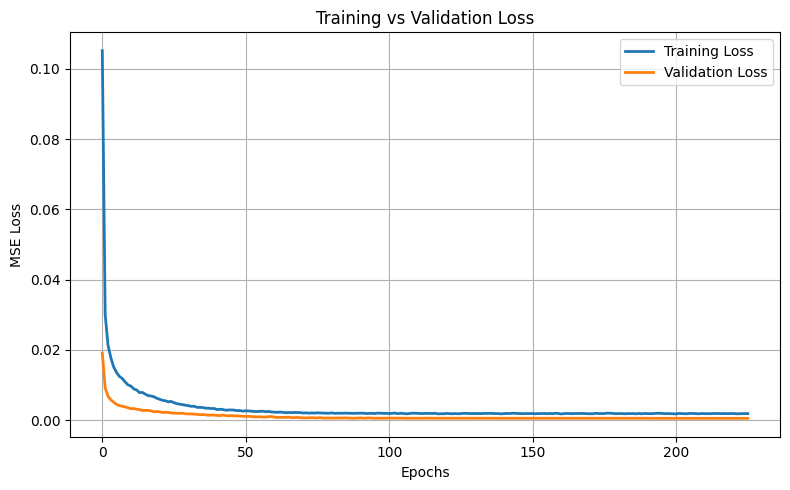

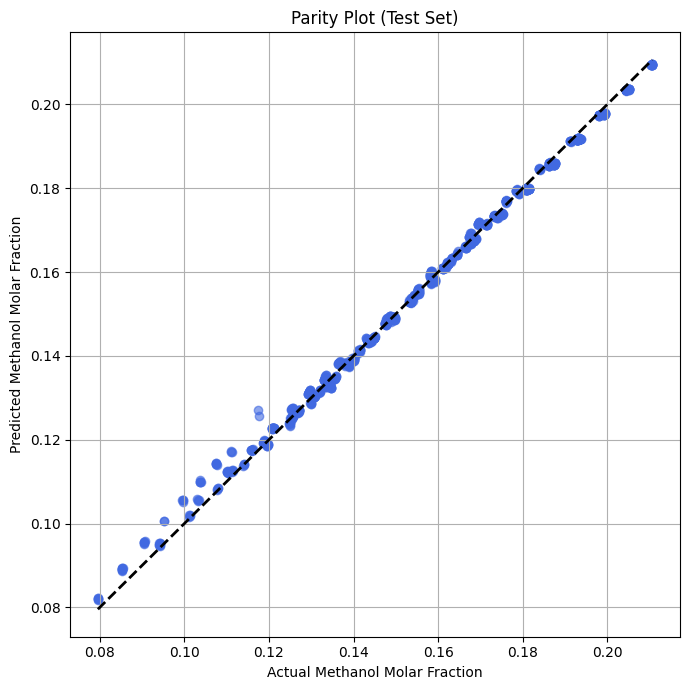

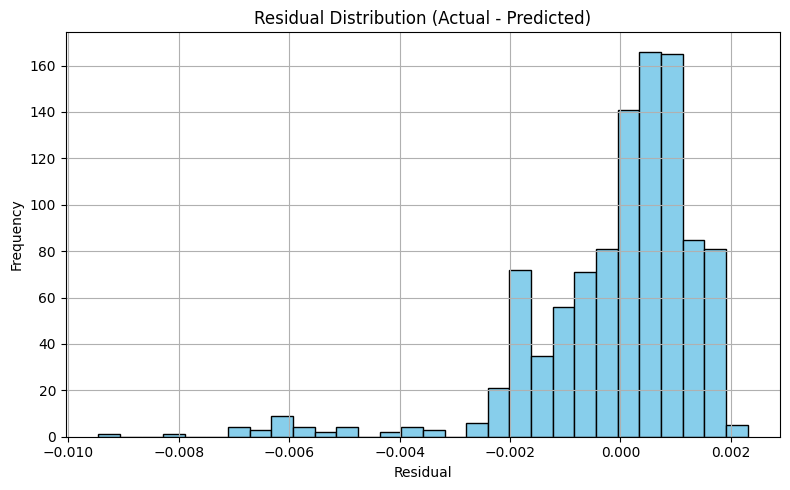

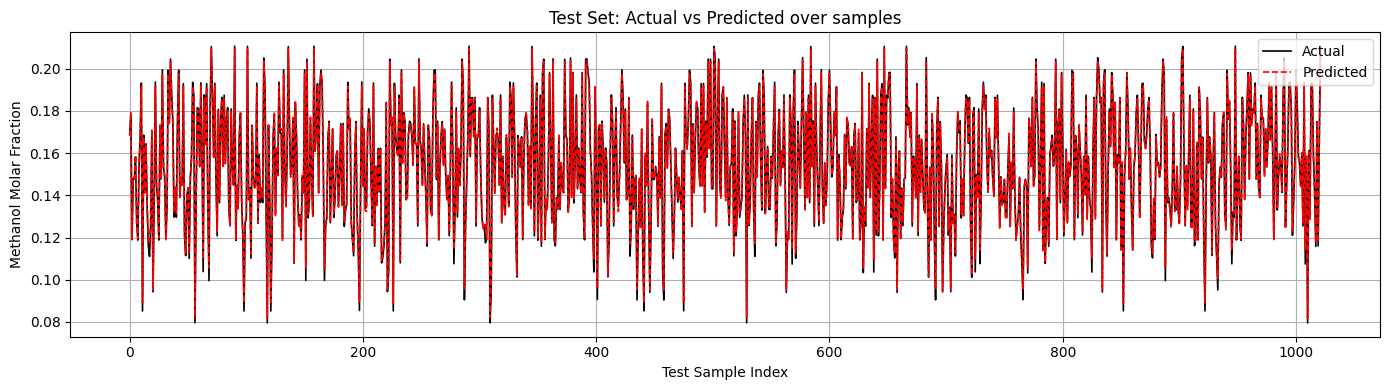

In [10]:
# ============================================================
# 8️⃣ VISUALIZATION
# ============================================================
import matplotlib.pyplot as plt

# Loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs'); plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Parity plot (Actual vs Predicted)
plt.figure(figsize=(7,7))
plt.scatter(y_true_test, y_pred_test, alpha=0.6, color='royalblue')
lo, hi = float(np.min(y_true_test)), float(np.max(y_true_test))
plt.plot([lo, hi], [lo, hi], 'k--', lw=2)
plt.xlabel('Actual Methanol Molar Fraction')
plt.ylabel('Predicted Methanol Molar Fraction')
plt.title('Parity Plot (Test Set)')
plt.grid(True); plt.tight_layout(); plt.show()

# Residuals histogram
residuals = y_true_test - y_pred_test
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Residual Distribution (Actual - Predicted)")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.grid(True); plt.tight_layout(); plt.show()

# Index plot (Actual vs Predicted)
idx = np.arange(len(y_true_test))
plt.figure(figsize=(14,4))
plt.plot(idx, y_true_test, '-', label='Actual', linewidth=1.2, color='black')
plt.plot(idx, y_pred_test, '--', label='Predicted', linewidth=1.2, color='red')
plt.xlabel('Test Sample Index'); plt.ylabel('Methanol Molar Fraction')
plt.title('Test Set: Actual vs Predicted over samples')
plt.legend(loc='upper right'); plt.grid(True); plt.tight_layout(); plt.show()


In [11]:
model.save("meoh_ann.keras")
import joblib; joblib.dump(scaler_x,"scaler_x.joblib"); joblib.dump(scaler_y,"scaler_y.joblib")


['scaler_y.joblib']

Cleaned columns:
 ['Row/Case', 'Status', 'VARY 1 HHX3 PARAM TEMP C', 'VARY 2 HHX3 PARAM PRES BAR', 'VARY 3 RECYCLE RECYCLED FRAC FRAC', 'VARY 4 SYNGAS MIXED TOTAL MO LEFLOW KMOL/HR', 'METHANOL molar fraction']
Detected methanol fraction column: METHANOL molar fraction
✅ Cleaned shape: (6808, 7)
Saved to: C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol_cleaned.xlsx
Auto-detected COL_FLOW as: VARY 4 SYNGAS MIXED TOTAL MO LEFLOW KMOL/HR
✅ Cleaned & randomized dataset loaded.
Total rows: 6808
Split sizes -> Train: 4765, Val: 1021, Test: 1022
✅ Data normalized successfully.
Sample weights summary -> min: 1.0000000000000002 median: 1.0000000000000002 max: 1.0000000000000002
Epoch 1/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0689 - mae: 0.1966 - val_loss: 0.0140 - val_mae: 0.0790 - learning_rate: 0.0010
Epoch 2/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - mae: 0.1177 - val_loss: 0.0088 - val_mae: 0.0567 - learning_rate: 0.0010
Epoch 3/400
75/75 ━━━━━━━━━━━━━━━━━━━━ 

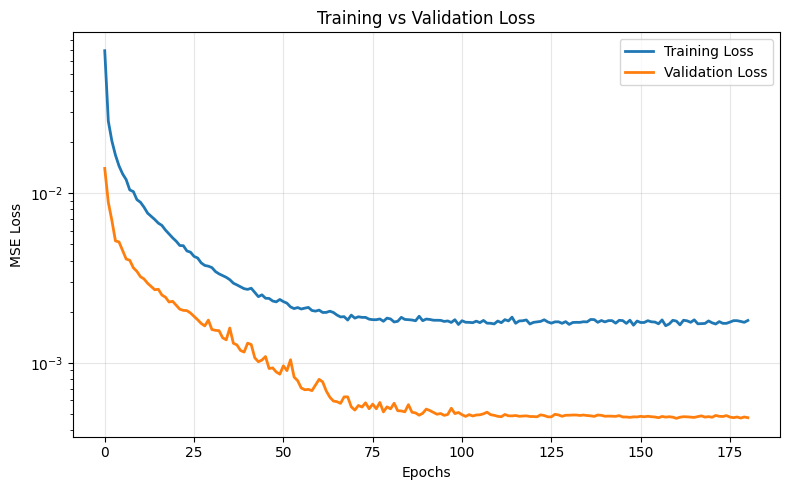

Residuals -> mean = 0.000014, std = 0.001334, min = -0.009322, max = 0.002293


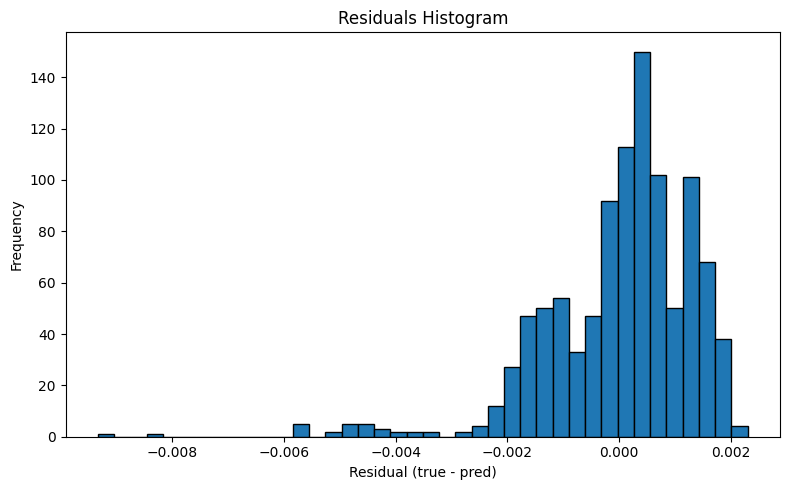

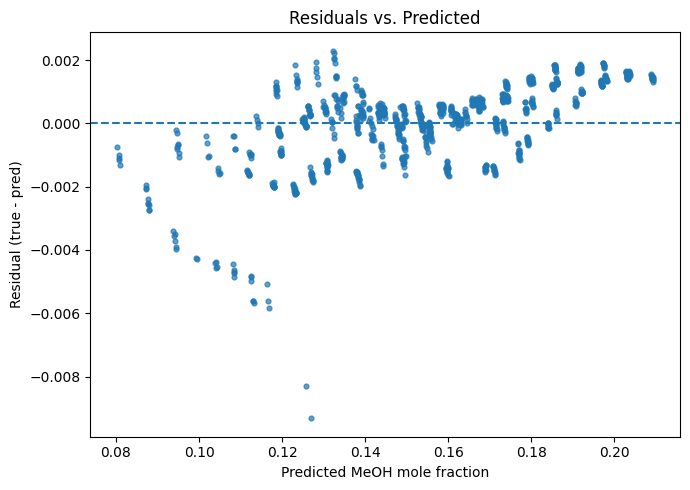

Artifacts saved: meoh_ann.keras, scaler_x.joblib, scaler_y.joblib


In [ ]:
# ============================================================
# Methanol Surrogate + Optimization (FULL SCRIPT)
# ============================================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) RAW → CLEAN EXCEL
# ----------------------------
file_path = r"C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol.xlsx"
df = pd.read_excel(file_path)

def clean_name(col: str) -> str:
    s = str(col)
    s = re.sub(r'_x000D_', ' ', s, flags=re.IGNORECASE)
    s = s.replace('\r', ' ').replace('\n', ' ')
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df.columns = [clean_name(c) for c in df.columns]
print("Cleaned columns:\n", df.columns.tolist())

# --- Find methanol molar fraction col ---
cands = []
for c in df.columns:
    lc = c.lower()
    if "methanol" in lc and ("molar" in lc or "mole" in lc) and "fraction" in lc:
        cands.append(c)
if not cands:
    for c in df.columns:
        lc = c.lower()
        if any(k in lc for k in ["xmeoh", "meoh x", "meoh_x", "molefrac_meoh"]):
            cands.append(c)
assert cands, "Couldn't find a 'methanol molar fraction' column."
methanol_col = cands[0]
print("Detected methanol fraction column:", methanol_col)

# --- Find Status column (case-insensitive) ---
status_col = None
for c in df.columns:
    if c.lower() == "status":
        status_col = c
        break
if status_col is None:
    for c in df.columns:
        if "status" in c.lower():
            status_col = c
            break
assert status_col is not None, "Couldn't find a 'Status' column."

# --- Coerce and filter OK rows with MeOH present ---
df[methanol_col] = pd.to_numeric(df[methanol_col], errors="coerce")
mask_ok = df[status_col].astype(str).str.strip().str.upper().eq("OK")
mask_has_meoh = df[methanol_col].notna()
df_clean = df[mask_ok & mask_has_meoh].copy().reset_index(drop=True)

print("✅ Cleaned shape:", df_clean.shape)
df_clean.head()

out_path = r"C:\Users\moham\OneDrive\Desktop\IOT\DATA\methanol_cleaned.xlsx"
df_clean.to_excel(out_path, index=False)
print("Saved to:", out_path)

# ----------------------------
# 2) CONFIGURATION
# ----------------------------
# Column names (from your cleaned file)
COL_TEMP  = 'VARY 1 HHX3 PARAM TEMP C'
COL_PRES  = 'VARY 2 HHX3 PARAM PRES BAR'
COL_RECYC = 'VARY 3 RECYCLE RECYCLED FRAC FRAC'
# Your earlier print had "TOTAL MO LEFLOW"; we normalize to the intended header:
try:
    COL_FLOW  = 'VARY 4 SYNGAS MIXED TOTAL MOLE FLOW KMOL/HR'
    _ = df_clean[COL_FLOW]
except KeyError:
    # robust fallback by pattern
    COL_FLOW = next(c for c in df_clean.columns
                    if ("SYNGAS" in c.upper()) and ("TOTAL" in c.upper())
                    and ("KMOL" in c.upper()) and ("FLOW" in c.upper()))
    print("Auto-detected COL_FLOW as:", COL_FLOW)

COL_Y     = methanol_col
INPUT_COLS = [COL_TEMP, COL_PRES, COL_RECYC, COL_FLOW]
OUTPUT_COLS = [COL_Y]

# Operating ranges
RANGE_TEMP  = (130.0, 281.1111)
RANGE_PRES  = (75.0, 150.0)
RANGE_RECYC = (0.75, 0.99)
RANGE_FLOW  = (8587.0, 11450.0)

# ----------------------------
# 3) LOAD CLEAN + SPLIT + SCALE
# ----------------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df2 = pd.read_excel(out_path)
for c in INPUT_COLS + OUTPUT_COLS:
    df2[c] = pd.to_numeric(df2[c], errors='coerce')
df2 = df2.dropna(subset=INPUT_COLS + OUTPUT_COLS).reset_index(drop=True)

# Randomize while preserving correlations
rng = np.random.default_rng(42)
perm = rng.permutation(len(df2))
df2 = df2.iloc[perm].reset_index(drop=True)

print("✅ Cleaned & randomized dataset loaded.")
print("Total rows:", len(df2))

train_df, temp_df = train_test_split(df2, test_size=0.30, random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=42)
print(f"Split sizes -> Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

scaler_x = MinMaxScaler().fit(train_df[INPUT_COLS])
scaler_y = MinMaxScaler().fit(train_df[OUTPUT_COLS])

X_train = scaler_x.transform(train_df[INPUT_COLS])
y_train = scaler_y.transform(train_df[OUTPUT_COLS])
X_val   = scaler_x.transform(val_df[INPUT_COLS])
y_val   = scaler_y.transform(val_df[OUTPUT_COLS])
X_test  = scaler_x.transform(test_df[INPUT_COLS])
y_test  = scaler_y.transform(test_df[OUTPUT_COLS])

print("✅ Data normalized successfully.")

# ----------------------------
# 4) DENSITY-BASED WEIGHTS
# ----------------------------
from sklearn.preprocessing import KBinsDiscretizer
n_bins = 10
kbd = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
bins = kbd.fit_transform(X_train).astype(int)
bin_ids = (bins[:,0]*(n_bins**3) + bins[:,1]*(n_bins**2) + bins[:,2]*n_bins + bins[:,3]).astype(int)
counts = np.bincount(bin_ids, minlength=n_bins**4).astype(float)
weights = 1.0 / (counts[bin_ids] + 1e-12)
weights /= np.mean(weights)
weights = np.clip(weights, 0, np.quantile(weights, 0.99))
print("Sample weights summary -> min:", weights.min(), "median:", np.median(weights), "max:", weights.max())

# ----------------------------
# 5) ANN TRAIN
# ----------------------------
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

tf.keras.backend.clear_session()

model = Sequential([
    Input(shape=(4,)),
    GaussianNoise(0.01),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
early   = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=64,
    callbacks=[early, plateau],
    verbose=1,
    sample_weight=weights
)

# ----------------------------
# 6) EVALUATE + PLOTS
# ----------------------------
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred_test_scaled = model.predict(X_test, verbose=0)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_true_test = scaler_y.inverse_transform(y_test)
y_pred_test = np.clip(y_pred_test, 0.0, 1.0)

r2  = r2_score(y_true_test, y_pred_test)
mse = mean_squared_error(y_true_test, y_pred_test)
mae = mean_absolute_error(y_true_test, y_pred_test)
print("\n📊 TEST SET PERFORMANCE:")
print(f"R² = {r2:.4f}")
print(f"MSE = {mse:.6f}")
print(f"MAE = {mae:.6f}")

# Loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history.get('loss', []), label='Training Loss', linewidth=2)
plt.plot(history.history.get('val_loss', []), label='Validation Loss', linewidth=2)
plt.xlabel('Epochs'); plt.ylabel('MSE Loss'); plt.yscale('log')
plt.title('Training vs Validation Loss')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Residuals
resid = (y_true_test.ravel() - y_pred_test.ravel())
print("Residuals -> mean = {:.6f}, std = {:.6f}, min = {:.6f}, max = {:.6f}"
      .format(np.mean(resid), np.std(resid), np.min(resid), np.max(resid)))

plt.figure(figsize=(8,5))
plt.hist(resid, bins=40, edgecolor='black')
plt.xlabel('Residual (true - pred)'); plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
plt.scatter(y_pred_test.ravel(), resid, s=12, alpha=0.7)
plt.axhline(0.0, linestyle='--')
plt.xlabel('Predicted MeOH mole fraction'); plt.ylabel('Residual (true - pred)')
plt.title('Residuals vs. Predicted'); plt.tight_layout(); plt.show()

# ----------------------------
# 7) SAVE ARTIFACTS
# ----------------------------
model.save("meoh_ann.keras")
import joblib
joblib.dump(scaler_x, "scaler_x.joblib")
joblib.dump(scaler_y, "scaler_y.joblib")
print("Artifacts saved: meoh_ann.keras, scaler_x.joblib, scaler_y.joblib")

# ============================================================
# 8) GLOBAL OPTIMIZATION + SENSITIVITY for a given FLOW
#    → Find max y and (T, P, R) that achieve it
# ============================================================

# Unpack ranges
T_MIN, T_MAX = RANGE_TEMP
P_MIN, P_MAX = RANGE_PRES
R_MIN, R_MAX = RANGE_RECYC
F_MIN, F_MAX = RANGE_FLOW

# If you later run only this block, auto-load artifacts:
from tensorflow.keras.models import load_model
try:
    _ = model
    _ = scaler_x
    _ = scaler_y
except NameError:
    import joblib as _joblib
    model = load_model("meoh_ann.keras")
    scaler_x = _joblib.load("scaler_x.joblib")
    scaler_y = _joblib.load("scaler_y.joblib")
    print("✅ Loaded model & scalers from disk.")

# Robust feature order (exactly what scaler_x was fit on)
try:
    FEATURE_ORDER = list(scaler_x.feature_names_in_)
except Exception:
    FEATURE_ORDER = INPUT_COLS  # fallback

# -------- Choose the syngas flow rate to analyze --------
FLOW_VALUE = 10500.0   # kmol/h

# -------- Settings for global search and refinement --------
N_SAMPLES = 50000       # number of global samples
TOP_K_REFINE = 8        # refine best K candidates
REFINE_ITERS = 12       # coordinate descent passes
GOLDEN_ITERS = 25       # iterations per golden search
IMPROVE_EPS = 1e-6      # min improvement threshold
N_SWEEP = 400           # number of points per sensitivity plot

def predict_meoh(T, P, R, FLOW):
    """Use trained surrogate model (vectorized)."""
    T = np.atleast_1d(T).astype(float)
    P = np.atleast_1d(P).astype(float)
    R = np.atleast_1d(R).astype(float)
    F = np.atleast_1d(FLOW).astype(float)
    if F.size == 1 and T.size > 1:
        F = np.full_like(T, F.item())
    X = np.column_stack([T, P, R, F])
    X_df = pd.DataFrame(X, columns=FEATURE_ORDER)
    Xs = scaler_x.transform(X_df)
    y_scaled = model.predict(Xs, verbose=0).reshape(-1, 1)
    y = scaler_y.inverse_transform(y_scaled).ravel()
    return np.clip(y, 0.0, 1.0)

def sample_TPR(n, seed=42):
    rng = np.random.default_rng(seed)
    T = rng.uniform(T_MIN, T_MAX, n)
    P = rng.uniform(P_MIN, P_MAX, n)
    R = rng.uniform(R_MIN, R_MAX, n)
    return T, P, R

def golden_max_1d(f, a, b, iters=GOLDEN_ITERS):
    phi = (1 + 5 ** 0.5) / 2
    invphi = 1 / phi
    c = b - (b - a) * invphi
    d = a + (b - a) * invphi
    fc = f(c); fd = f(d)
    for _ in range(iters):
        if fc > fd:
            b, d, fd = d, c, fc
            c = b - (b - a) * invphi
            fc = f(c)
        else:
            a, c, fc = c, d, fd
            d = a + (b - a) * invphi
            fd = f(d)
    x = (a + b) / 2
    return x, f(x)

def refine(flow, T0, P0, R0, passes=REFINE_ITERS, eps=IMPROVE_EPS):
    T, P, R = float(T0), float(P0), float(R0)
    y_best = predict_meoh(T, P, R, flow)[0]
    for _ in range(passes):
        improved = False
        fT = lambda t: predict_meoh(t, P, R, flow)[0]
        T_new, y_new = golden_max_1d(fT, T_MIN, T_MAX)
        if y_new > y_best + eps:
            T, y_best = T_new, y_new
            improved = True
        fP = lambda p: predict_meoh(T, p, R, flow)[0]
        P_new, y_new = golden_max_1d(fP, P_MIN, P_MAX)
        if y_new > y_best + eps:
            P, y_best = P_new, y_new
            improved = True
        fR = lambda r: predict_meoh(T, P, r, flow)[0]
        R_new, y_new = golden_max_1d(fR, R_MIN, R_MAX)
        if y_new > y_best + eps:
            R, y_best = R_new, y_new
            improved = True
        if not improved:
            break
    return T, P, R, y_best

# Guard flow range
assert F_MIN <= FLOW_VALUE <= F_MAX, f"FLOW {FLOW_VALUE} outside training range!"

# Global random search
T_s, P_s, R_s = sample_TPR(N_SAMPLES, seed=42)
F_s = np.full_like(T_s, FLOW_VALUE, dtype=float)
y_s = predict_meoh(T_s, P_s, R_s, F_s)

# Refine top-K
best_idx = np.argsort(-y_s)[:TOP_K_REFINE]
candidates = []
for i in best_idx:
    T0, P0, R0 = T_s[i], P_s[i], R_s[i]
    T1, P1, R1, y1 = refine(FLOW_VALUE, T0, P0, R0)
    candidates.append((y1, T1, P1, R1))
candidates.sort(reverse=True, key=lambda t: t[0])
y_opt, T_opt, P_opt, R_opt = candidates[0]

print("\n================= OPTIMUM @ FLOW =================")
print(f"FLOW (kmol/h): {FLOW_VALUE:.4f}")
print(f"T_opt (°C)   : {T_opt:.6f}")
print(f"P_opt (bar)  : {P_opt:.6f}")
print(f"R_opt (-)    : {R_opt:.8f}")
print(f"y* (mole frac): {y_opt:.8f}")
print("==================================================")

# PLOTS: SENSITIVITY CURVES
# y vs T
T_grid = np.linspace(T_MIN, T_MAX, 400)
y_T = predict_meoh(T_grid, P_opt, R_opt, FLOW_VALUE)
plt.figure(figsize=(7,5))
plt.plot(T_grid, y_T, lw=2); plt.axvline(T_opt, ls='--', color='red')
plt.scatter([T_opt], [y_opt], color='red', zorder=3)
plt.xlabel("Temperature (°C)"); plt.ylabel("Methanol mole fraction")
plt.title(f"Effect of Temperature (Flow={FLOW_VALUE:.0f} kmol/h)")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# y vs P
P_grid = np.linspace(P_MIN, P_MAX, 400)
y_P = predict_meoh(T_opt, P_grid, R_opt, FLOW_VALUE)
plt.figure(figsize=(7,5))
plt.plot(P_grid, y_P, lw=2); plt.axvline(P_opt, ls='--', color='red')
plt.scatter([P_opt], [y_opt], color='red', zorder=3)
plt.xlabel("Pressure (bar)"); plt.ylabel("Methanol mole fraction")
plt.title(f"Effect of Pressure (Flow={FLOW_VALUE:.0f} kmol/h)")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# y vs R
R_grid = np.linspace(R_MIN, R_MAX, 400)
y_R = predict_meoh(T_opt, P_opt, R_grid, FLOW_VALUE)
plt.figure(figsize=(7,5))
plt.plot(R_grid, y_R, lw=2); plt.axvline(R_opt, ls='--', color='red')
plt.scatter([R_opt], [y_opt], color='red', zorder=3)
plt.xlabel("Recycle ratio (-)"); plt.ylabel("Methanol mole fraction")
plt.title(f"Effect of Recycle ratio (Flow={FLOW_VALUE:.0f} kmol/h)")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Optional: T-P contour at R*
MAKE_CONTOUR = True
if MAKE_CONTOUR:
    NT, NP = 80, 80
    Tm = np.linspace(T_MIN, T_MAX, NT)
    Pm = np.linspace(P_MIN, P_MAX, NP)
    TT, PP = np.meshgrid(Tm, Pm, indexing="xy")
    YY = predict_meoh(TT.ravel(), PP.ravel(),
                      np.full(TT.size, R_opt),
                      np.full(TT.size, FLOW_VALUE))
    YY = YY.reshape(TT.shape)
    plt.figure(figsize=(8,6))
    cs = plt.contourf(TT, PP, YY, levels=18)
    plt.colorbar(cs, label="Methanol mole fraction")
    plt.scatter([T_opt], [P_opt], c="black", s=40, label="Optimum")
    plt.xlabel("Temperature (°C)"); plt.ylabel("Pressure (bar)")
    plt.title(f"T-P Influence Map (Flow={FLOW_VALUE:.0f}, R={R_opt:.4f})")
    plt.legend(); plt.tight_layout(); plt.show()
